# Thực hành về mạng GAN

In [ ]:
# !nvidia-smi
# from google.colab import drive
# drive.mount('/content/drive')
# !pip3 install torchsummary
# !pip3 install torchvision

### Chuẩn bị các thư viện cần thiết

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import glob
import cv2
import torch.nn.functional as F
from torch.autograd import Variable

import torchvision
import torchvision.transforms as transforms

from torch.nn import CrossEntropyLoss, Dropout, Softmax, Linear, Conv2d, LayerNorm
import matplotlib.pyplot as plt
from torchsummary import summary

### Thiết lập các hằng số cho tập MNIST

In [ ]:
width    = 28
height   = 28
channels = 1
epochs   = 100

img_shape = (width, height, channels)

<H2>1. Tải tập dữ liệu MNIST</H2>

Ta chỉ dùng tập huấn luyện, không dùng nhãn. Các điểm ảnh được chuẩn hoá về miền giá trị [-1, 1] 

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5))])

batch_size = 32

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Trực quan dữ liệu MNIST

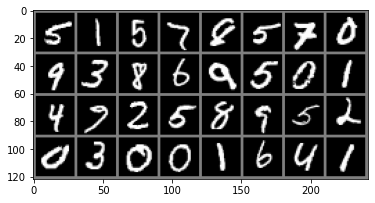

    5     1     5     7     8     5     7     0     9     3     8     6     9     5     0     1     4     9     2     5     8     9     5     2     0     3     0     0     1     6     4     1


In [ ]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % labels[j].item() for j in range(batch_size)))

<H2>2. Generator</H2>
Lập trình kiến trúc Generator theo mô tả phía dưới

In [ ]:
""" Declare GENERATOR. 
    + Its input is a 100-feature vector of random noise
    + Its output is a fake image with pixel values in [-1, 1]"""

class Generator(nn.Module):
    
    ##########################
    ###   YOUR CODE HERE   ###
    ##########################
    def __init__(self):
      super(Generator,self).__init__()
      self.fc1 = nn.Linear(100, 256)
      self.lrelu = nn.LeakyReLU(0.2)
      self.bn1 = nn.BatchNorm1d(256)
      self.fc2 = nn.Linear(256,512)
      self.bn2 = nn.BatchNorm1d(512)
      self.fc3 = nn.Linear(512,1024)
      self.bn3 = nn.BatchNorm1d(1024)
      self.fc4 = nn.Linear(1024,784)
      self.tanh = nn.Tanh()
    def forward(self,x):
      # x = x.view(-1,100)
      # print(x.shape)
      x = self.lrelu(self.fc1(x))
      x = self.bn1(x)
      x = self.lrelu(self.fc2(x))
      x = self.bn2(x)
      x = self.lrelu(self.fc3(x))
      x = self.bn3(x)
      x = self.tanh(self.fc4(x))
      return x.view(-1,1,28,28)

G = Generator().cuda()
summary(G, (100, ), batch_size=-1, device='cuda')
print("_____________________ Generator Created_____________________")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 256]          25,856
         LeakyReLU-2                  [-1, 256]               0
       BatchNorm1d-3                  [-1, 256]             512
            Linear-4                  [-1, 512]         131,584
         LeakyReLU-5                  [-1, 512]               0
       BatchNorm1d-6                  [-1, 512]           1,024
            Linear-7                 [-1, 1024]         525,312
         LeakyReLU-8                 [-1, 1024]               0
       BatchNorm1d-9                 [-1, 1024]           2,048
           Linear-10                  [-1, 784]         803,600
             Tanh-11                  [-1, 784]               0
Total params: 1,489,936
Trainable params: 1,489,936
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forw

<H2>3. Discriminator</H2>
Lập trình kiến trúc Discriminator

In [ ]:
""" Declare DISCRIMINATOR 
    Its input is REAL IMAGE (in a form of a vector 28x28)
    Its ouput is the probability of image type (REAL IMAGE or FAKE IMAGE)
    the values in the range of [0, 1] """

class Discriminator(nn.Module):
    ##########################
    ###   YOUR CODE HERE   ###
    ##########################
    def __init__(self):
      super(Discriminator,self).__init__()
      self.fc1 = nn.Linear(28*28,256)
      self.relu = nn.ReLU()
      # self.fc2 = nn.Linear(256,256)
      self.fc3 = nn.Linear(256,1)
      self.sigmoid = nn.Sigmoid()
    def forward(self,x):
      x = x.view(-1,28*28)
      x = self.relu(self.fc1(x))
      # x = self.relu(self.fc2(x))
      x = self.sigmoid(self.fc3(x))
      return x

D = Discriminator().cuda()
summary(D, img_shape, batch_size=-1, device='cuda')
print("____________________ Discriminator Created____________________")


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 256]         200,960
              ReLU-2                  [-1, 256]               0
            Linear-3                    [-1, 1]             257
           Sigmoid-4                    [-1, 1]               0
Total params: 201,217
Trainable params: 201,217
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.77
Estimated Total Size (MB): 0.77
----------------------------------------------------------------
____________________ Discriminator Created____________________


<h2>4. Generative model</h2>

Xây dựng GAN và huấn luyện

In [ ]:
##########################
###   YOUR CODE HERE   ###
##########################
optimizer_D = optim.Adam(D.parameters(),lr = 0.1 )
optimizer_G = optim.Adam(G.parameters(),lr = 0.1)
criter = nn.BCELoss() 


losses_G = []
losses_D = []
samples = []

In [ ]:
def Gen(optimizer_G,z,G,criter,valid):
  optimizer_G.zero_grad()
  gen_imgs = G(z)
  out_d = D(gen_imgs)
  g_loss = criter(out_d, valid)
  reset_grad()
  g_loss.backward(retain_graph=True)
  optimizer_G.step()
  return g_loss
def Dis(optimizer_D,z,D,criter,valid,fake,real_imgs):
  optimizer_D.zero_grad()
  
  # print(gen_imgs.shape)
  # print(real_imgs.shape)
  output = D(real_imgs)
  d_loss_real = criter(output, valid)
  D_real_score = output
  gen_imgs = G(z)
  output = D(gen_imgs)
  d_loss_fake = criter(output,fake)
  D_fake_score = output

  d_loss = d_loss_real + d_loss_fake
  reset_grad()
  # d_loss_real.backward()
  # d_loss_fake.backward()
  d_loss.backward()
  optimizer_D.step()
  return d_loss
  # return d_loss_real + d_loss_fake
def reset_grad():
    optimizer_D.zero_grad()
    optimizer_G.zero_grad()


In [ ]:
for epoch in range(epochs):
    for (i, (imgs, _)) in enumerate(trainloader, start=1):
        # Adversarial ground truths
        valid = Variable(torch.cuda.FloatTensor(imgs.size(0), 1).fill_(1.0), requires_grad=False) #real label
        fake = Variable(torch.cuda.FloatTensor(imgs.size(0), 1).fill_(0.0), requires_grad=False) #fake label
        # print(imgs)
        # Configure input
        imgs = imgs.type(torch.cuda.FloatTensor)
        real_imgs = Variable(imgs)
        
        # print(real_imgs.shape)
        # -----------------
        #  Train Generator
        # -----------------

        # optimizer_G.zero_grad()

        # Sample noise as generator input
        z = Variable(torch.cuda.FloatTensor(np.random.normal(0, 1, (imgs.shape[0], 100)))) #noise

        # Generate a batch of images
        # gen_imgs = G(z)
        # print(gen_imgs.shape)
        # Loss measures generator's ability to fool the discriminator

        ##########################
        ###   YOUR CODE HERE   ###
        ##########################
        # out_d = D(gen_imgs)
        # g_loss = criter(out_d, valid)
        # reset_grad()
        # g_loss.backward(retain_graph=True)
        # optimizer_G.step()
        g_loss = Gen(optimizer_G,z,G,criter,valid)

        # # ---------------------
        # #  Train Discriminator
        # # ---------------------

        # optimizer_D.zero_grad()

        # Loss measures discriminator's ability to classify real from generated samples

        ##########################
        ###   YOUR CODE HERE   ###
        ##########################
        # output = D(real_imgs)
        # d_loss_real = criter(output, valid)
        # D_real_score = output

        # output = D(gen_imgs)
        # d_loss_fake = criter(output,fake)
        # D_fake_score = output

        # d_loss = d_loss_real + d_loss_fake
        # reset_grad()
        # d_loss.backward()
        # optimizer_D.step()

        d_loss = Dis(optimizer_D,z,D,criter,valid,fake,real_imgs)

        if epoch % 10 == 0 and i == len(trainloader):
            print(
                "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
                % (epoch, epochs, i, len(trainloader), d_loss.item(), g_loss.item())
            )
            
            losses_G.append(g_loss.item())
            losses_D.append(d_loss.item())
            samples.append(gen_imgs)


[Epoch 0/100] [Batch 1875/1875] [D loss: 100.000000] [G loss: 100.000000]
[Epoch 10/100] [Batch 1875/1875] [D loss: 100.000000] [G loss: 100.000000]
[Epoch 20/100] [Batch 1875/1875] [D loss: 100.000000] [G loss: 100.000000]
[Epoch 30/100] [Batch 1875/1875] [D loss: 100.000000] [G loss: 100.000000]
[Epoch 40/100] [Batch 1875/1875] [D loss: 100.000000] [G loss: 100.000000]
[Epoch 50/100] [Batch 1875/1875] [D loss: 100.000000] [G loss: 100.000000]
[Epoch 60/100] [Batch 1875/1875] [D loss: 100.000000] [G loss: 100.000000]
[Epoch 70/100] [Batch 1875/1875] [D loss: 100.000000] [G loss: 100.000000]
[Epoch 80/100] [Batch 1875/1875] [D loss: 100.000000] [G loss: 100.000000]
[Epoch 90/100] [Batch 1875/1875] [D loss: 100.000000] [G loss: 100.000000]


### Vẽ đồ thị hàm loss huấn luyện

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(list(range(len(losses_G)/10)*10), losses_G, label="G_loss")
plt.plot(list(range(len(losses_D)/10)*10), losses_D, label="D_loss")
plt.title("Training losses", fontsize=16)
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Losses", fontsize=14)
plt.legend(loc="upper right", fontsize=14)
plt.show()

TypeError: ignored

<Figure size 864x432 with 0 Axes>

### Trực quan hoá kết quả sinh dữ liệu của mô hình đã huấn luyện

    ____________________ Step = 0 ____________________    ____________________ Step = 0 ____________________    ____________________ Step = 0 ____________________    ____________________ Step = 0 ____________________    ____________________ Step = 0 ____________________    ____________________ Step = 0 ____________________    ____________________ Step = 0 ____________________    ____________________ Step = 0 ____________________    ____________________ Step = 0 ____________________    ____________________ Step = 0 ____________________


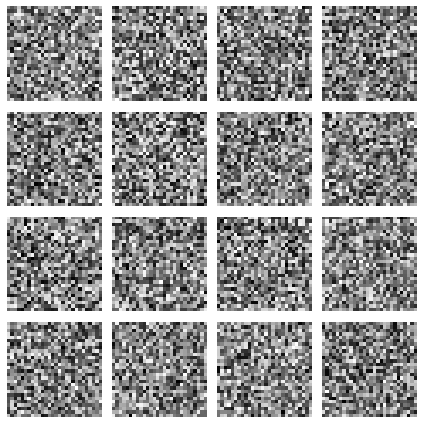



    ____________________ Step = 10 ____________________    ____________________ Step = 10 ____________________    ____________________ Step = 10 ____________________    ____________________ Step = 10 ____________________    ____________________ Step = 10 ____________________    ____________________ Step = 10 ____________________    ____________________ Step = 10 ____________________    ____________________ Step = 10 ____________________    ____________________ Step = 10 ____________________    ____________________ Step = 10 ____________________


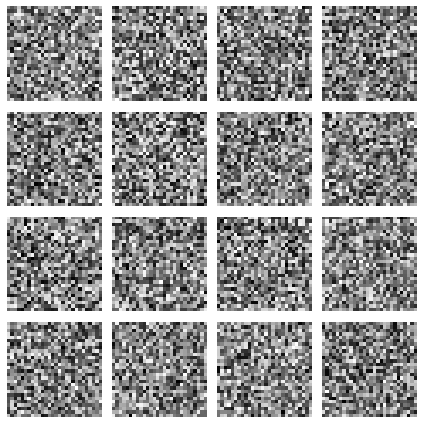

In [ ]:
i = 0
for i in range(0, len(samples), 10):
    images = samples[i].data.cpu().numpy()
    print("    ____________________ Step = %d ____________________" % i*10)
    plt.figure(figsize=(6, 6))
    for i in range(16):
        plt.subplot(4, 4, i+1)
        image = images[i, :, :, :]
        image = np.reshape(image, [height, width])
        plt.imshow(image, cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.show()
    print("\n")

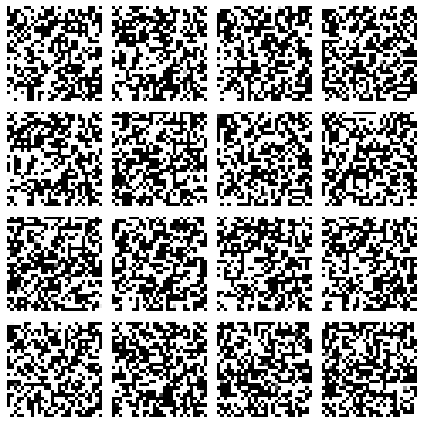

In [ ]:
noise = torch.Tensor(np.random.normal(0, 1, (16, 100))).cuda()
gen_images = G(noise)
images = gen_images.data.cpu().numpy()
plt.figure(figsize=(6, 6))
for i in range(16):
    plt.subplot(4, 4, i+1)
    image = images[i, :, :, :]
    image = np.reshape(image, [height, width])
    plt.imshow(image, cmap='gray')
    plt.axis('off')
plt.tight_layout()
plt.show()